In [3]:
"""Pakete für die Analyse"""
import pandas as pd
import folium as fm
import geopandas as gpd
import numpy as np
import datetime as dt

"""Paket als Exemplar"""
import matplotlib.pyplot as plt

"""Paket für die Punktanalyse"""
# from geopy import Nominatim

'Paket für die Punktanalyse'

In [4]:
"""Rohdaten laden; Data_CVD; Geodata_Ger; Geodata_PLZ"""


### Daten bestehend aus Datum, PLZ ###
def get_cvd_data(file: str = "Data/data.csv") -> pd.DataFrame:
    
    D = []
#     D_df = pd.read_csv(filepath_or_buffer=file, sep=';', header=None, names=['Datum','plz'], dtype={'Datum': str,'plz':str })
#     D_df['Datum']= pd.to_datetime(D_df['Datum'],day_first=True, format="%d.%m.%Y", errors='ignore', )
    
    with open( f'{file}', 'r') as f: 
        
        for line in f:
            
            #Extrahieren der Variablen
            Datum, PLZ = line.strip().split(';')
            Tag,Monat,Jahr = Datum.split('.')

            #Formatierung der Daten zur optimalen Weiterverarbeitung
            PLZ = str(PLZ)
            Tag = int(Tag)
            Monat = int(Monat)
            Jahr = int(Jahr)
            #Datum zum rechnen
            Datum = dt.date(day= Tag, month= Monat, year= Jahr)
            
            #Zusammenführen der Daten
            D.append((Datum, PLZ))

            
        D_df = pd.DataFrame(D, columns = ["Datum","plz"])
        D_df.sort_values('Datum', ignore_index=True)
    #Rückgabe als PandaDataFrame    
    return D_df


### Daten bestehend aus Polygonen von ganz Deutschland sortiert nach PLZ ###
def get_geo_data() -> gpd.GeoDataFrame:
    
    plz_shape_ger = gpd.read_file('Data/plz-gebiete.shp', dtype={'plz': str})
    
    return plz_shape_ger


### Daten bestehend aus allen Postleitzahlen, Orten und Landkreisen aus Deutschland###
def get_plz_data () -> pd.DataFrame:
    
    plz_zuordnung = pd.read_csv('Data/zuordnung_plz_ort_landkreis.csv', dtype={'plz': str})
    
    return plz_zuordnung

In [5]:
data_cvd = get_cvd_data()
data_plz = get_plz_data()
data_geo_ger = get_geo_data()

data_cvd


,Datum,plz
0,2020-01-01,64823
1,2020-01-01,64395
2,2020-01-01,64405
3,2020-01-01,64846
4,2020-01-01,64807
...,...,...
33895,2020-12-31,64839
33896,2020-12-31,64397
33897,2020-12-31,64287
33898,2020-12-31,64401


In [6]:
"""Funktionen um die zu Daten verarbeiten und in die gewünschte Form zu bringen"""

### nur den gewünschten Ort einblenden
def plz_shape_from_list(geodata: gpd.GeoDataFrame, plz_list: list) -> gpd.GeoDataFrame:
    
    geo_df = geodata[geodata['plz'].isin(plz_list)]
    
    return geo_df


### pos. Fälle an einem Tag anzeigen
def cases_a_day(data: pd.DataFrame, date: dt.date, start: int, stop: int) -> pd.DataFrame:
    
    begin = date - dt.timedelta(days = stop)
    end = date + dt.timedelta(days = start)
    pos_cases_in_a_day = data[data['Datum'].between(begin, end, inclusive=True)]

    return pos_cases_in_a_day
    

### pos. Fälle an einem Tag zählen und nach PLZ sortieren
def day_counts_heatmap(data: pd.DataFrame, date: dt.date, inf_begin: int, inf_end: int) -> pd.DataFrame:
    
    day_data = cases_a_day(data, date, inf_begin, inf_end)
    heatmap_day = pd.DataFrame(day_data['plz'].value_counts())
    heatmap_day.columns = ['Faelle']
    heatmap_day.reset_index(inplace=True)
    heatmap_day = heatmap_day.rename(columns = {'index':'plz'})
    
    return heatmap_day

### Daten von einem Tag zusammenführen für Matplotlib (aus der Heatmap- und Geo-Data)
def merge_heat_with_geo(geodata: gpd.GeoDataFrame, data: pd.DataFrame, date: dt.date):
    
    geodata_heat = pd.merge(
        left=geodata, 
        right=data, 
        on='plz',
        how='left'
        )
    
    Anhang = [date]*len(geodata_heat['plz'])
    geodata_heat = geodata_heat.fillna(0)
    geodata_heat.insert(1, 'Datum', Anhang)

    return geodata_heat

### Eine Color-Map erstellen
# def cmap_create(data, column):


### Eine Json Datei erzeugen für Folium
def geojson_create(geodata:gpd.GeoDataFrame):
    
    gdf = geodata.drop(columns='note').set_index('plz')
    geojson = gdf.to_json()
    
    return geojson
    
    
### Daten fürs TimeSliderChoropleth bearbeiten
def data_Choropleth(data: pd.DataFrame,
                    geodata: gpd.GeoDataFrame,
                    Begin: dt.date,
                    End: dt.date,
                    inf_beg: int,
                    inf_end: int):
    
    td = dt.timedelta(days=1)
    i = Begin
    df = 0
    gdf = geodata.drop(columns=['geometry','note'])
    begin = Begin - dt.timedelta(days=inf_end)
    end = End + dt.timedelta(days=inf_beg)
    relevant = data[data['Datum'].between(begin, end, inclusive=True)]
    
    while i<=End:
        
        heatdata = day_counts_heatmap(relevant, i, inf_beg, inf_end) 
        geodata_heatmap = merge_heat_with_geo(gdf, heatdata, i)
        if i == Begin:
            df = geodata_heatmap
        else: 
            df = df.append(geodata_heatmap)   
        i+=td
        
    return pd.DataFrame(df)

### ZeitFormat für stylesheet ändern
def change_time(df):
    
    Datum_U10 = []
    
    for date in df['Datum']:
        t = date.strftime('%s')
        Datum_U10.append(t)
        
    df = df.drop(columns=['Datum'])
    df.insert(1, 'Datum', Datum_U10)
    
    return pd.DataFrame(df)
    
def fill_color_and_opacity(df):
    
    max_c = df['Faelle'].max()
    min_c = df['Faelle'].min()
    
    from branca.colormap import linear
    cmap = linear.PuRd_09.scale(min_c, max_c)
    
    opacity  = df['Faelle'] / max_c
    df.insert(3, 'Opacity', opacity)
    
    df['Faelle'] = df['Faelle'].map(cmap)
    
    return pd.DataFrame(df), cmap
    
    
def stylesheet(data):
    
    df_time = change_time(data)
    df, cmap = fill_color_and_opacity(df_time)

    styledict = {}
    df = df.sort_values(by=['plz','Datum'], ignore_index=True)

    for i, j in df.iterrows():
        if j[0] not in styledict:
            styledict[j[0]]={}
        styledict[j[0]].update({j[1]: { "color" : j[2], "opacity" : j[3] }})
   
    return styledict


def data_HeatmapTime(data: pd.DataFrame,
                    geodata: gpd.GeoDataFrame,
                    Begin: dt.date,
                    End: dt.date,
                    inf_beg: int,
                    inf_end: int):
    
    td = dt.timedelta(days=1)
    i = Begin
    df = 0
    
    gdf = geodata.copy()
    gdf['geometry'] = gdf['geometry'].centroid
    gdf = gdf.drop(columns=['note'])
    
    beg = Begin - dt.timedelta(days=inf_end)
    end = End + dt.timedelta(days=inf_beg)
    relevant = data[data['Datum'].between(beg, end, inclusive=True)]
    
    while i<=End:
        
        heatdata = day_counts_heatmap(relevant, i, inf_beg, inf_end) 
        geodata_heatmap = merge_heat_with_geo(gdf, heatdata, i)
        if i == Begin:
            df = geodata_heatmap
        else: 
            df = df.append(geodata_heatmap)   
        i+=td
        
        
    df = pd.DataFrame(df)
    df['Faelle']=df['Faelle'].div(df['Faelle'].max())
    index = list(df['Datum'])
    
    heat_data=[]
    for i, j in df.iterrows():
        heat_data.append((j[2],j[3]))
    
    
    

    
    
    return heat_data, index

In [7]:
data_cvd = get_cvd_data()
data_plz = get_plz_data()
data_geo_ger = get_geo_data()

Darmstadt=[49.877, 8.651]

plz_dadi = ['64665', '64832', '64404', '64807', '64859','64390', '64405', '64347', '64395',
            '64401', '64823', '64846', '64409', '64397', '64367','64839', '64372', '64853',
            '64319', '64354', '64380', '64850', '64342', '64331', '64283','64285', '64287',
            '64289', '64291', '64293', '64295', '64297']

geodata_dadi = plz_shape_from_list(data_geo_ger, plz_dadi)

Erster_Tag = dt.date(day=20,month=12,year=2020)
Letzter_Tag = dt.date(day=1,month=1,year=2021)
inf_Beginn = 2
inf_Ende = 10

In [8]:
"""Die verschiedenen Funktionen zum zum Anzeigen"""

### Die Gegend anzeigen mit Matplotlib
def plot_map_of_area(geodata: gpd.GeoDataFrame):
    
    plt.rcParams['figure.figsize'] = [30, 30]
    fig, ax = plt.subplots()

    map_of_area = geodata.plot(
        ax=ax, 
        column='note',
        alpha=0.5,
        categorical=True,
        edgecolor='black',
        legend=True,
        legend_kwds={'loc': 'upper left', 'ncol': 5 },
        cmap=plt.cm.plasma_r
    )

    ax.set_title('Die Gegend Da-Di', fontdict = {'fontsize': 20})
    ax.set(facecolor='lightblue');
    
    return map_of_area

### Die Gegend anzeigen als Heatmap von einem Tag
def heatmap_of_a_day(geodata: gpd.GeoDataFrame,
                     data: pd.DataFrame,
                     date: dt.date,
                     inf_beg: int,
                     inf_end: int):
    fig, ax = plt.subplots()
    plt.rcParams['figure.figsize'] = [30, 30]
    
    heatdata = day_counts_heatmap(data, date, inf_beg, inf_end)
    geodata_heatmap = merge_heat_with_geo(geodata, heatdata, date)
    
    heatmap_day = geodata_heatmap.plot(
        ax=ax, 
        column='Faelle', 
        categorical=False, 
        legend=True, 
        cmap=plt.cm.plasma_r
    )
    
    ax.set_title(f'DaDi: Fälle am Tag {date}', fontdict = {'fontsize': 30})
    ax.set(facecolor='lightblue');
    
    return heatmap_day

### Erzeugt eine zoombare Choropleth Map über Folium
def create_Choropleth(location, geodata, data, day, beg, end):     
    
    Choro_map = fm.Map(location=location, zoom_start=10, control_scale=True)
    
    df = data_Choropleth(data,geodata,day,day,beg,end)
    df_geo = geojson_create(geodata)
    
    
    fm.Choropleth(geo_data=df_geo,
                     name="Heatmap",
                     data=df,
                     columns=['plz', 'Faelle'],
                     fill_color= 'PuRd', #BuGn OrRd BuPu GnBu PuBu PuBuGn PuRd RdPu YlGn YlGnBu YlOrBr YlOrRd
                     fill_opacity = 0.3,
                     line_capacity=.1,
                     legend_name= 'Faelle',
                     show_legend= True,
                     key_on="feature.id",
                     nan_fill_color='white'
                     ).add_to(Choro_map)
    
    return Choro_map 


### Mit Zeitverlauf
def Time_Slider_Choropleth(location,
                         data: pd.DataFrame,
                         geodata: gpd.GeoDataFrame,
                         first_day: dt.date,
                         last_day: dt.date,
                         inf_beg: int,
                         inf_end: int):
    
    from folium.plugins import TimeSliderChoropleth
    
    df_chrono = data_Choropleth(data,geodata,first_day,last_day,inf_beg,inf_end)
    
    geojson = geojson_create(geodata)
    
    style = stylesheet(df_chrono)
    
    final_map = fm.Map(location=location, zoom_start=10, control_scale=True)    
    
    TimeSliderChoropleth(data=geojson,
                         styledict=style,
                         name="Heatmap_time",
                         overlay=True,
                         control = True,
                         show = True).add_to(final_map)
    
    final_map.add_child(fm.LayerControl())
    final_map.save("HeatmapTime.html")
    
    return final_map

def Time_Slider_Heatmap(location,
                         data: pd.DataFrame,
                         geodata: gpd.GeoDataFrame,
                         first_day: dt.date,
                         last_day: dt.date,
                         inf_beg: int,
                         inf_end: int):
    
    from folium.plugins import HeatMapWithTime
    
    heat_data, index = data_HeatmapTime(data,geodata,first_day,last_day,inf_beg,inf_end)
        
    final_map = fm.Map(location=location, zoom_start=10, control_scale=True)    
    
    HeatMapWithTime(data=heat_data,
                         
                         name="Heatmap_time",
                         overlay=True,
                         control = True,
                        scale_radius= True,
                    
                         show = True).add_to(final_map)
    
    final_map.add_child(fm.LayerControl())
    final_map.save("HeatmapWithTime.html")
    
    return final_map



/Users/m/opt/anaconda3/envs/ox/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 159 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/m/opt/anaconda3/envs/ox/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 159 missing from current font.
  font.set_text(s, 0, flags=flags)


<AxesSubplot:title={'center':'Die Gegend Da-Di'}>

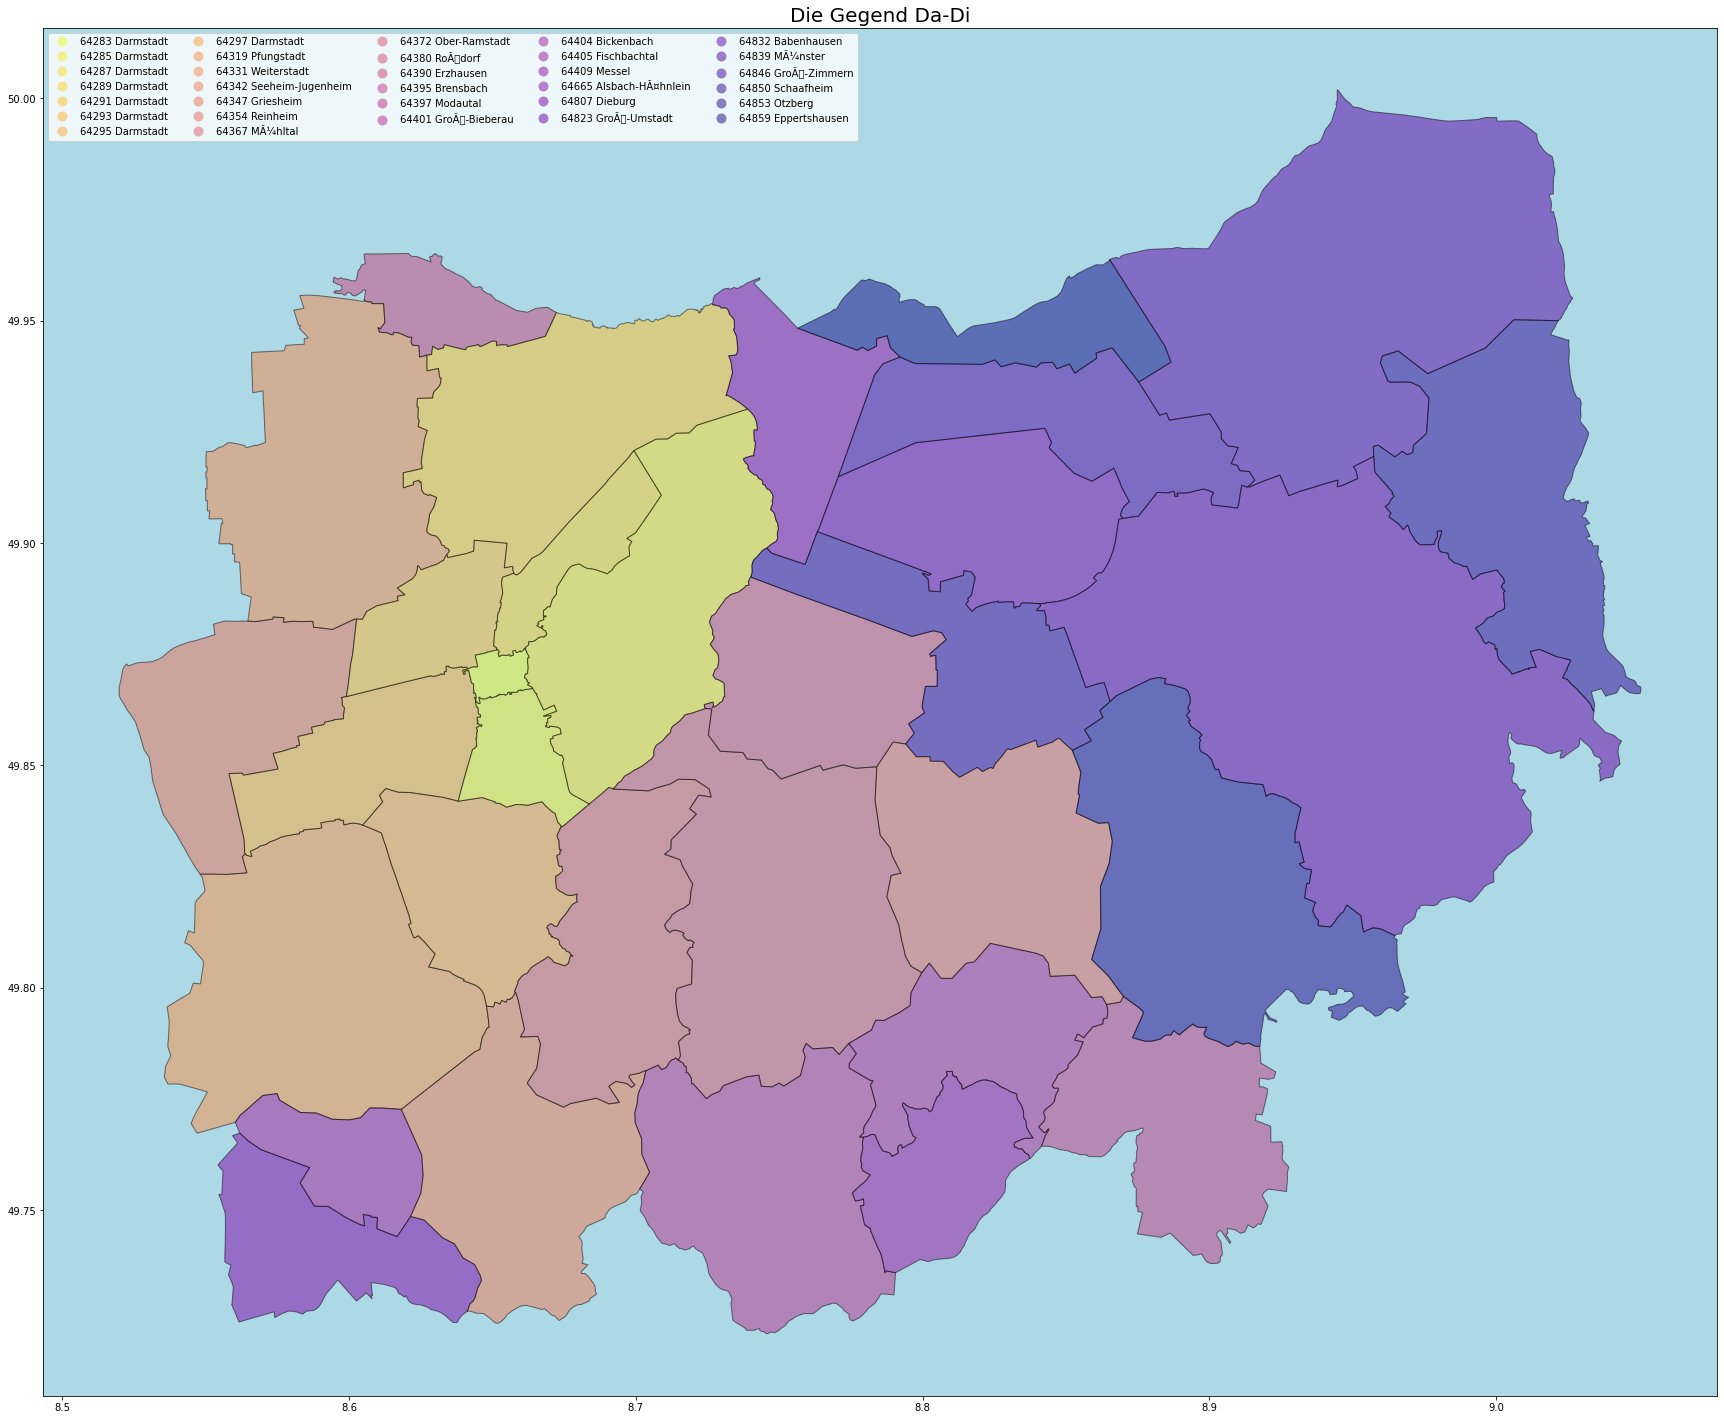

In [9]:
plot_map_of_area(geodata_dadi)

<AxesSubplot:title={'center':'DaDi: Fälle am Tag 2020-12-20'}>

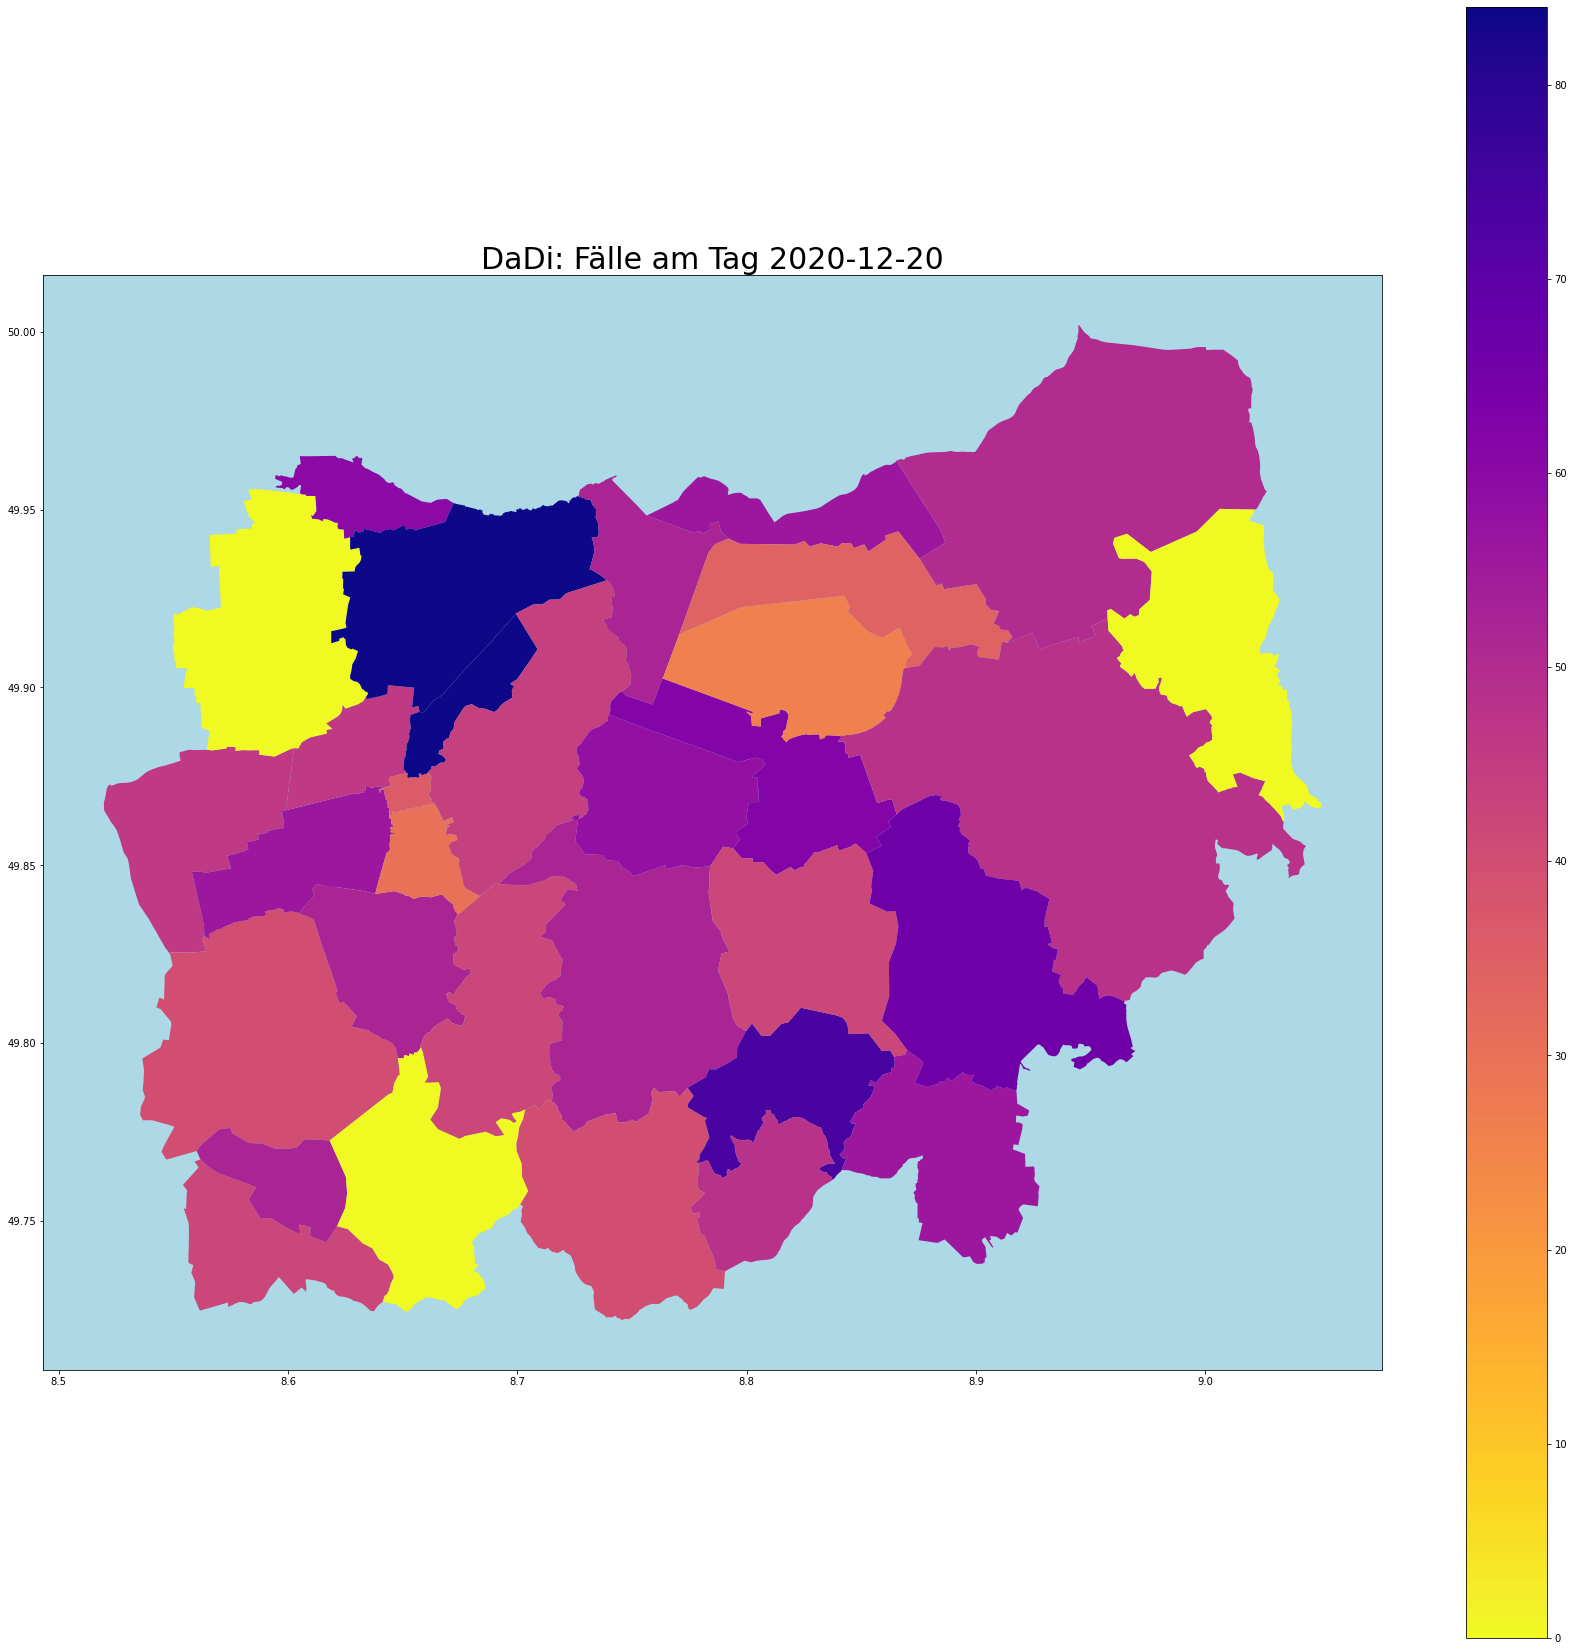

In [10]:
heatmap_of_a_day(geodata_dadi, data_cvd, Erster_Tag, 0, 14)

In [11]:
create_Choropleth(Darmstadt, geodata_dadi, data_cvd, Letzter_Tag, inf_Beginn, inf_Ende)

In [12]:
data_cvd = get_cvd_data()
data_plz = get_plz_data()
data_geo_ger = get_geo_data()

Darmstadt=[49.877, 8.651]

plz_dadi = ['64665', '64832', '64404', '64807', '64859','64390', '64405', '64347', '64395',
            '64401', '64823', '64846', '64409', '64397', '64367','64839', '64372', '64853',
            '64319', '64354', '64380', '64850', '64342', '64331', '64283','64285', '64287',
            '64289', '64291', '64293', '64295', '64297']
geodata_dadi = plz_shape_from_list(data_geo_ger, plz_dadi)

Erster_Tag = dt.date(day=1,month=1,year=2020)
Letzter_Tag = dt.date(day=1,month=1,year=2021)
inf_Beginn = 2
inf_Ende = 14

In [13]:
Time_Slider_Choropleth(Darmstadt, data_cvd, geodata_dadi, Erster_Tag, Letzter_Tag, inf_Beginn, inf_Ende)

In [136]:
"""
Mögliche Erkenntnisse:
- Übertragungen auf andere Infektionskrankheiten:
    - Wo treten Sie häufig auf?
    - Wo lässt sich präventive Arbeit effektiver einsetzen?
    - In welchen Orten/Bereichen lohnt sich ein genauerer Blick?
    - Wo gibt es evtl. Infektionsherde?
    

Mögliche weitere Anwendungen:
- eine Funktion um sich die Veränderung und Bewgung der Infizierten anzuschauen.
- so lässt sich eine Mobilitätskarte erzeugen
- Flüsse (Veränderungen) anzeigen lassen, Annsteckungsketten
- Einrichtung auf der Karte anzeigen lassen, um zu schauen ob es einen Zusammenhang mit lokalen Maxima gibt.
- Über Punkte (Strasse,PLZ), eine genauere Heatmap erzeugen und nachschauen ob es in bestimmten Gebieten
  vermehrt zu Infektionen kommt
- mehrere Lagen mit verschiedenen Informationen lassen sich kombinieren
- andere Daten können genauso gut analysiert werden
"""

'\nMögliche Erkenntnisse:\n- Übertragungen auf andere Infektionskrankheiten:\n    - Wo treten Sie häufig auf?\n    - Wo lässt sich präventive Arbeit effektiver einsetzen?\n    - In welchen Orten/Bereichen lohnt sich ein genauerer Blick?\n    - Wo gibt es evtl. Infektionsherde?\n    \n\nMögliche weitere Anwendungen:\n- eine Funktion um sich die Veränderung und Bewgung der Infizierten anzuschauen.\n- so lässt sich eine Mobilitätskarte erzeugen\n- Flüsse (Veränderungen) anzeigen lassen, Annsteckungsketten\n- Einrichtung auf der Karte anzeigen lassen, um zu schauen ob es einen Zusammenhang mit lokalen Maxima gibt.\n- Über Punkte (Strasse,PLZ), eine genauere Heatmap erzeugen und nachschauen ob es in bestimmten Gebieten\n  vermehrt zu Infektionen kommt\n- mehrere Lagen mit verschiedenen Informationen lassen sich kombinieren\n- andere Daten können genauso gut analysiert werden\n'